# Logistic regression and Naive Bayes from scratch #
1. implement a logistic regression with cross-entropy loss function
2. implement a naive bayes algorithm using for the $P(x_{i}|class=k)=N(\mu_{k},\sigma_{k})$
3. test both in cross-validation on the iris dataset
* for the measure of accuracy, and cross-validation use sklearn classification_report and cohen_kappa_score
* for the cross-validation use KFold 
* to evaluate the results use the Union of all the prediction and comapre them with the Union of the test labels


(150, 4)


,c0,c1,c2,c3,target
0,6.1,3.0,4.6,1.4,1.0
1,6.5,3.0,5.2,2.0,2.0
2,6.1,2.6,5.6,1.4,2.0
3,5.0,3.4,1.5,0.2,0.0
4,6.5,3.0,5.8,2.2,2.0


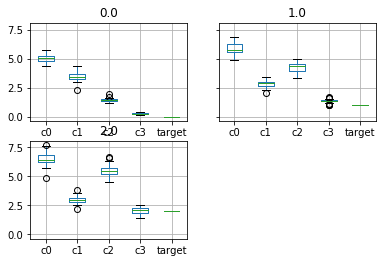

In [1]:
%matplotlib inline
import sklearn 
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import pandas as pd
import os
import tarfile
import urllib
import numpy as np
from  sklearn import datasets

from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import train_test_split


iris = datasets.load_iris()
X = iris.data
y = iris.target
N = X.shape[0]
print(X.shape)

NL = int(N*0.60)
NT = N - NL
indices = np.random.permutation(X.shape[0])

XL, yL = X[indices[:NL]], y[indices[:NL]]
XT, yT = X[indices[NL:]], y[indices[NL:]]



df = pd.DataFrame(np.hstack((XL,yL.reshape(yL.shape[0],1))), columns=["c"+str(i) for i in range(4)]+["target"])
df.groupby(df.columns[-1]).count()
df.groupby(df.columns[-1]).boxplot()
Count1=df.groupby(df.columns[-1]).count()
df.head()



In [2]:
K=max(yL)+1 #number of classes
K

3

# Naive Bayes method #




In [3]:
#here I define function that compute gaussian distribution
def gaussian_distr(sigma, mu, x):
    denom=sigma*np.sqrt(2*np.pi)
    expon=(x-mu)**2/(2*sigma)
    g_distr=np.exp(-expon)/denom
    return g_distr

In [4]:
mu_m=df.groupby(df.columns[-1]).mean()

In [5]:
sigma_m=df.groupby(df.columns[-1]).std()

In [6]:
#this function returns the probability of belonging to a class, 
#parameters mu_M and sigma_M are from dataframe groupby, so they are neither arrays nor lists
#if we need to use this function for array and lists mu_M and sigma_M, we have to modify the iloc[j,k] with [j][k]

def Naive_bayes(x, y,kappa, mu_M, sigma_M):
    Gauss_M=np.zeros((kappa, len(x.T)))
    Defin=np.ones((len(x),kappa))
    for i in range (len(x)):#i is for the data points
        for k in range (kappa):#k is for the classes
            for j in range (len(x.T)): #j is for the features
                Gauss_M[k][j]=gaussian_distr(sigma_M.iloc[k,j], mu_M.iloc[k,j], x[i][j])
            q=Gauss_M[k].prod()
            Defin[i][k]=q*Count1.iloc[k,0]   
    return Defin

#print(Naive_bayes_func(XT, K, yT, df)) 

In [7]:
def estimate_Prediction(y_pred_prob): #from probability of belonging to a class to prediction

    prediction=np.ones(((len(y_pred_prob)),1))
    for i in range (len(y_pred_prob)):
        prediction[i]=np.argmax(y_pred_prob[i])
        
    return prediction

Y_pred=estimate_Prediction(Naive_bayes(XT, yT,K, mu_m, sigma_m))
#print(Y_pred)

In [8]:
#this function returns the accuracy calculated from scratch
def accuracy(y_pred, y):
    c=0
    m=len(y)
    for i in range (m):
        if y_pred[i]==y[i]:
            c+=1
    return c/m

accuracy(Y_pred,yT)

0.95

In [9]:
cohen=cohen_kappa_score(Y_pred,yT)
cohen

0.9245599329421627

In [10]:
print(classification_report(Y_pred,yT))


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        22
         1.0       1.00      0.87      0.93        23
         2.0       0.83      1.00      0.91        15

    accuracy                           0.95        60
   macro avg       0.94      0.96      0.95        60
weighted avg       0.96      0.95      0.95        60



 # Logistic Regression with cross-entropy #


In [11]:
#this function add a column of ones for bias
def add_bias(x):
    n=len(x)
    x0=np.ones((n,1))
    x1=np.concatenate((x0,x), axis=1)
    return x1
#this function creates the one hot encoding matrix from a 1-d array
def one_hot_enc_matrix(y):
    y1=np.zeros((len(y), K))
    for g in range (0,(len(y))):
        y1[g,y[g]]=1
        #print(y[g])
    return y1

def exp_z(x, beta):
    Z=np.dot(x, beta)
    prob=np.exp(Z)
    return prob

In [12]:
def Cross_entropy(x1, y1, tmax, alpha): #tmax number of iterations, alpha learning rate
    n=len(x1)
    theta=np.zeros((len(x1.T), K)) #theta has dimension = number of features + 1 (bias/intercept), classes
    Norm=np.zeros((len(x1), K))
    prop=np.zeros((len(x1), K))
    tau=1
    
    while tau < tmax:
        prop=exp_z(x1, theta)
        for i in range (n):
            Norm[i]=prop[i].sum()  
        prop_norm=prop/Norm
        theta = theta - (alpha/n)*np.dot(x1.T,(prop_norm-y1))
        tau += 1
            
    return theta

In [13]:
def pred_cross_entr(x1, beta):
    prop=exp_z(x1, beta)
    Norm=np.zeros((len(x1), K))
    for i in range (len(x1)):
        Norm[i]=prop[i].sum()
    prop_norm=prop/Norm
    
    return prop_norm

In [14]:
def cross_En_loss(y_pred, y, kappa):
    m=len(y)
    
    #calculate cross entropy loss function for the y_pred I found
    summation1=np.ones((len(y_pred), kappa))
    summation2=np.ones((len(y_pred), 1))
    
    for i in range (m):
        for k in range (kappa):
            summation1[i][k]=y[i][k]*np.log(y_pred[i][k])
        summation2[i]= summation1[i].sum()
        
    loss_c_e=-(1/m)*summation2.sum()   

    return loss_c_e

In [15]:

numK=10 #here it's possible to choose the number of folds
kf = KFold(n_splits=numK,shuffle=True, random_state=None)
score_tot=[]
parameters=[]

yL_h=one_hot_enc_matrix(yL)
yT_h=one_hot_enc_matrix(yT)
XL_b=add_bias(XL)
XT_b=add_bias(XT)

score_tot=[]
parameters=[]

for gamma in np.arange(0.02, 1.5, 0.02, dtype="float32"):
    for t_max in range (10, 800, 100):
        prediction=[]
        ytest=[]
        for train_index, test_index in kf.split(XL_b):
            #print("TRAIN:", train_index, "TEST:", test_index)
            X_train_b, X_test_b = XL_b[train_index], XL_b[test_index]
            y_train_h,y_test_h = yL_h[train_index], yL_h[test_index]
            y_train, y_test = yL[train_index], yL[test_index]
            beta=Cross_entropy(X_train_b, y_train_h, t_max, gamma)
            Y_prob=pred_cross_entr(X_test_b, beta)
            Y_predict=estimate_Prediction(Y_prob)
    
            prediction.extend(Y_predict)
            ytest.extend(y_test)
        cohen=cohen_kappa_score(prediction,ytest)
        #print(cohen)     

        score_tot.append(cohen)
        parameters.append((gamma,t_max))



In [16]:
hyperpar_best= parameters[np.argmax(score_tot)]
alpha_best=hyperpar_best[0]
t_max_best=hyperpar_best[1]

beta_best=Cross_entropy(XL_b, yL_h, t_max_best, alpha_best)

Y_prob=pred_cross_entr(XT_b, beta_best)
Y_predict=estimate_Prediction(Y_prob)

print("Best hyperparameters are (alpha, t max)", hyperpar_best)
print("Cohen score for test set is ", cohen_kappa_score(Y_predict,yT))
print("Table of classification report for test set \n", classification_report(Y_predict,yT))

Best hyperparameters are (alpha, t max) (0.17999999, 710)
Cohen score for test set is  0.9249374478732277
Table of classification report for test set 
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        22
         1.0       0.85      1.00      0.92        17
         2.0       1.00      0.86      0.92        21

    accuracy                           0.95        60
   macro avg       0.95      0.95      0.95        60
weighted avg       0.96      0.95      0.95        60



In [17]:
print("Loss calculated on test set is", cross_En_loss(Y_prob, yT_h, K))
print("Accuracy calculated on test set is ", accuracy(Y_predict, yT))

Loss calculated on test set is 0.13754539016342507
Accuracy calculated on test set is  0.95


I added to the analysis a heatmap that shows how cohen score changes, if alpha and t_max vary. 
In this way we can note consequent behaviors as, for example, the fact that if we have a small learning rate we can have fairly good performace even with fewer iterations but if we are seeking the best possible performance we still need to have a higher number of iterations. We can observe that for large part of learning rate values the number of iteration needed to perform well (cohen circa 0.9 for example) is approximately 200.

Text(0.5, 51.0, 'Learning rate')

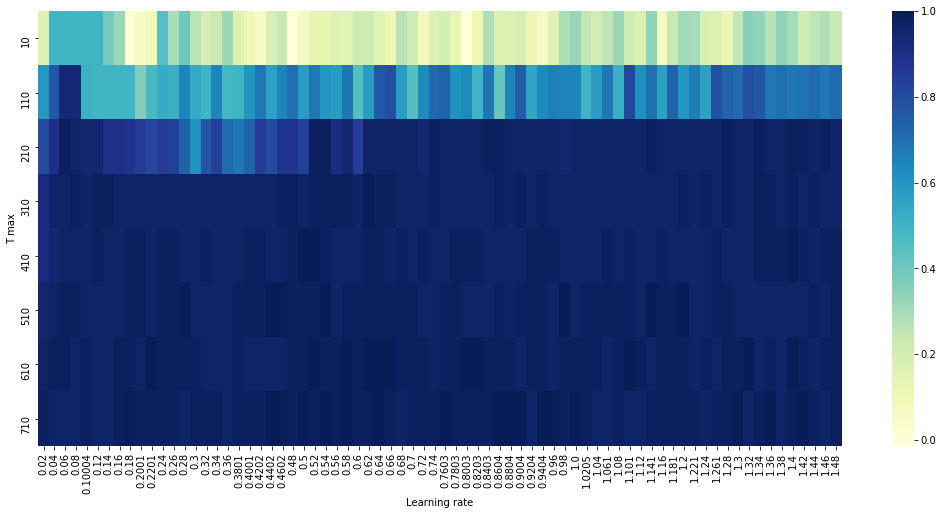

In [18]:
import seaborn as sbn
a=np.arange (10, 800, 100)
b=np.arange (0.02, 1.5, 0.02, dtype="float16")
#print(len(b))
#a and b must be the same to the ones in for cycles of k fold


score_totNP=np.array(score_tot)
S=score_totNP.reshape((len(b),len(a))).T

fig = plt.figure(figsize=[18,8])

sbn.heatmap(S, yticklabels=a,xticklabels=b, cmap="YlGnBu")

plt.ylabel('T max')
plt.xlabel('Learning rate')